In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import re

In [2]:
df = pd.read_csv('pga_stats.csv', low_memory=False)

In [3]:
df.head(3)

,Player Name,Putting_from_6_ROUNDS,Putting_from_6_% MADE,Putting_from_6_ATTEMPTS,Putting_from_6_PUTTS MADE,Total_3_Putts_-_10-15_ROUNDS,Total_3_Putts_-_10-15_TOTAL 3 PUTTS 10'-15',Total_3_Putts_-_10-15_TOTAL 3 PUTTS,Putting_from_-__25_ROUNDS,Putting_from_-__25_% MADE,...,Year,Putts_per_Round_-_Round_5_AVG,Putts_per_Round_-_Round_5_TOTAL PUTTS,Putts_per_Round_-_Round_5_TOTAL ROUNDS,One-Putt_Percentage_-_Round_5_%,One-Putt_Percentage_-_Round_5_# OF 1 PUTTS,One-Putt_Percentage_-_Round_5_# OF HOLES,3-Putt_Avoidance_-_Round_5_%,3-Putt_Avoidance_-_Round_5_TOTAL 3 PUTTS,3-Putt_Avoidance_-_Round_5_TOTAL HOLES
0,Martin Piller,30.0,87.50,24.0,21.0,NaN,NaN,NaN,30.0,4.55,...,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jonathan Byrd,43.0,86.67,30.0,26.0,43.0,1.0,17.0,43.0,2.50,...,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Michael Kim,51.0,86.49,37.0,32.0,NaN,NaN,NaN,51.0,3.97,...,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Columns: 1167 entries, Player Name to 3-Putt_Avoidance_-_Round_5_TOTAL HOLES
dtypes: float64(1004), int64(1), object(162)
memory usage: 44.2+ MB


In [5]:
f'Null Values: {df.isna().sum().sum()}'

'Null Values: 4623040'

In [6]:
df = df.dropna(thresh=500)
df = df.dropna(thresh=500, axis=1)

In [7]:
import util
df.loc[:,df.dtypes == object] = df.loc[:,df.dtypes == object].applymap(util.make_numeric)
df.loc[:,df.dtypes == object] = df.loc[:,df.dtypes == object].applymap(lambda df:  0 if df=='E' else df)

In [8]:
df.columns

Index(['Player Name', 'Putting_from_6_ROUNDS', 'Putting_from_6_% MADE',
       'Putting_from_6_ATTEMPTS', 'Putting_from_6_PUTTS MADE',
       'Total_3_Putts_-_10-15_ROUNDS',
       'Total_3_Putts_-_10-15_TOTAL 3 PUTTS 10'-15'',
       'Total_3_Putts_-_10-15_TOTAL 3 PUTTS', 'Putting_from_-__25_ROUNDS',
       'Putting_from_-__25_% MADE',
       ...
       'Average_Approach_Distance_-_Bogey_or_Worse_AVG (YARDS)',
       'Average_Approach_Distance_-_Bogey_or_Worse_TOTAL DISTANCE (INCHES)',
       'Average_Approach_Distance_-_Bogey_or_Worse_NUMBER OF APPROACH SHOTS',
       'GIR_Percentage_from_Fairway_ROUNDS', 'GIR_Percentage_from_Fairway_%',
       'GIR_Percentage_from_Fairway_GREENS HIT',
       'GIR_Percentage_from_Fairway_# OF HOLES',
       'Approach_225-250_yards_RTP_ROUNDS',
       'Approach_225-250_yards_RTP_AVG RTP', 'Year'],
      dtype='object', length=1136)

In [9]:
df = df.fillna(df.mean())

players = df.loc[:,'Player Name']
df = df.drop('Player Name', axis=1)

# Drop Object Columns that did not convert
df = df.drop(df.loc[:,df.dtypes == object], axis=1)

In [10]:
f'Null Values: {df.isna().sum().sum()}'

'Null Values: 0'

In [11]:
df.columns

Index(['Putting_from_6_ROUNDS', 'Putting_from_6_% MADE',
       'Putting_from_6_ATTEMPTS', 'Putting_from_6_PUTTS MADE',
       'Total_3_Putts_-_10-15_ROUNDS',
       'Total_3_Putts_-_10-15_TOTAL 3 PUTTS 10'-15'',
       'Total_3_Putts_-_10-15_TOTAL 3 PUTTS', 'Putting_from_-__25_ROUNDS',
       'Putting_from_-__25_% MADE', 'Putting_from_-__25_ATTEMPTS',
       ...
       'Average_Approach_Distance_-_Bogey_or_Worse_AVG (YARDS)',
       'Average_Approach_Distance_-_Bogey_or_Worse_TOTAL DISTANCE (INCHES)',
       'Average_Approach_Distance_-_Bogey_or_Worse_NUMBER OF APPROACH SHOTS',
       'GIR_Percentage_from_Fairway_ROUNDS', 'GIR_Percentage_from_Fairway_%',
       'GIR_Percentage_from_Fairway_GREENS HIT',
       'GIR_Percentage_from_Fairway_# OF HOLES',
       'Approach_225-250_yards_RTP_ROUNDS',
       'Approach_225-250_yards_RTP_AVG RTP', 'Year'],
      dtype='object', length=1132)

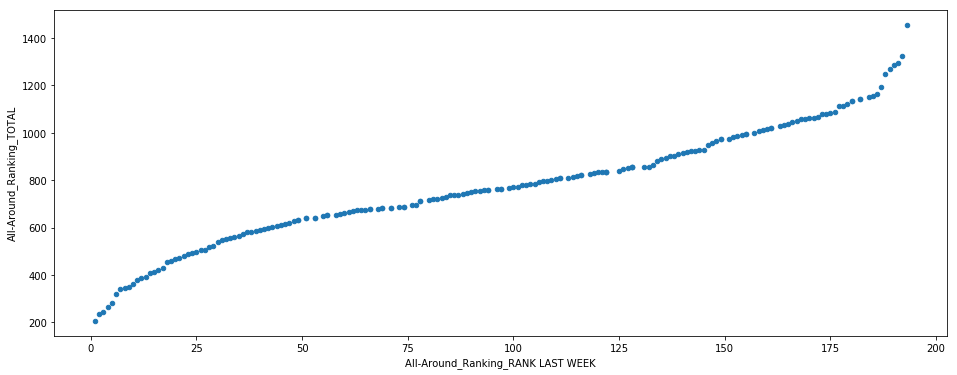

In [12]:
ranking = pd.read_csv(r'data/2018/POINTSRANKINGS/All-Around_Ranking.csv')
ranking['All-Around_Ranking_RANK LAST WEEK'] = ranking['All-Around_Ranking_RANK LAST WEEK'].str.replace('T','').map(int)
ranking.plot(kind='scatter', x='All-Around_Ranking_RANK LAST WEEK', y='All-Around_Ranking_TOTAL', figsize=(16,6));

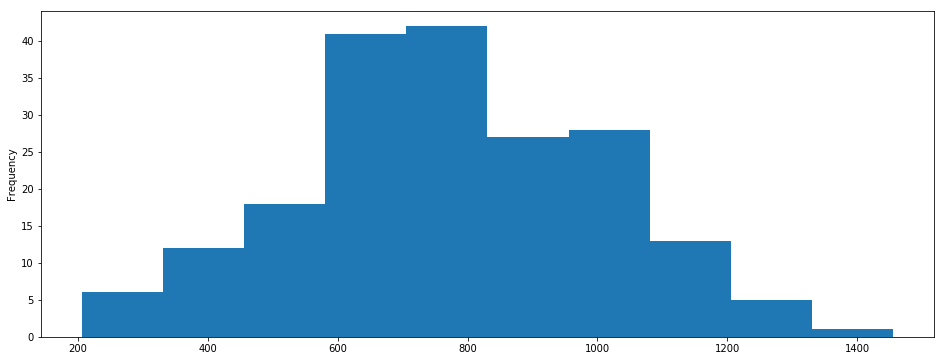

In [13]:
ranking['All-Around_Ranking_TOTAL'].plot(kind='hist', figsize=(16,6));

In [14]:
target = df[['All-Around_Ranking_TOTAL', 'Year']]
feature = df.drop('All-Around_Ranking_TOTAL', axis=1)

feature_train = feature[~feature['Year'].isin([2018])]
target_train = target[~target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']

feature_test = feature[feature['Year'].isin([2018])]
target_test = target[target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']

rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1)
rfr.fit(feature_train, target_train)
target_predict = rfr.predict(feature_test)

print('Random Forest Results:')
print(f'R Squared: {r2_score(target_test, target_predict)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(target_test, target_predict))}')

target_mean = target_test.map(lambda x: target_test.mean())

print('Mean Model Results:')
print(f'R Squared: {r2_score(target_test, target_mean)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(target_test, target_mean))}')

feature_importance_df = pd.DataFrame({'feature': feature_train.columns, 'importance': rfr.feature_importances_})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

Random Forest Results:
R Squared: 0.8245844967911304
Root Mean Squared Error: 99.2545213180364
Mean Model Results:
R Squared: 0.0
Root Mean Squared Error: 236.98251948756112


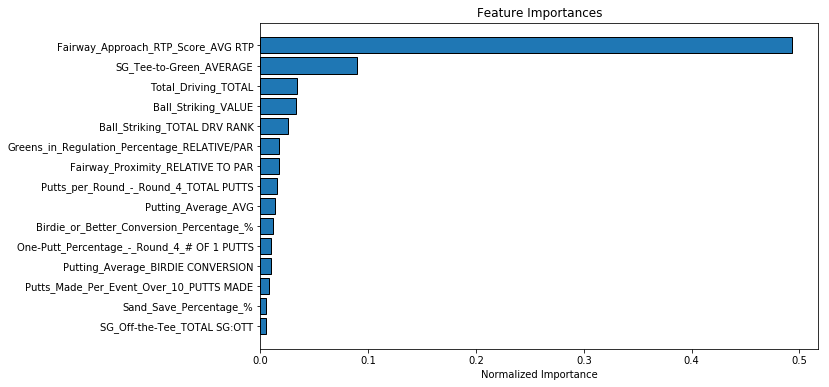

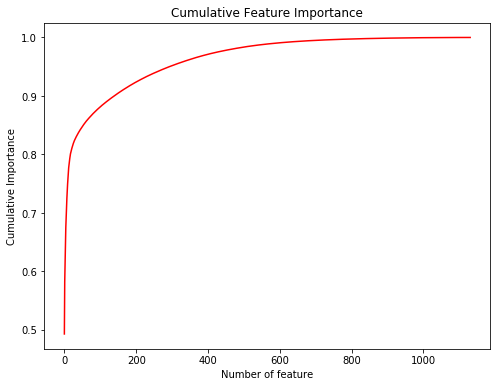

7 feature required for 0.70 of cumulative importance


In [15]:
df = feature_importance_df.sort_values('importance', ascending=False).reset_index()

df['importance_normalized'] = df['importance'] / df['importance'].sum()
df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

plt.figure(figsize=(10, 6))
ax = plt.subplot()

ax.barh(list(reversed(list(df.index[:15]))),
        df['importance_normalized'].head(15),
        align='center', edgecolor='k')

ax.set_yticks(list(reversed(list(df.index[:15]))))
ax.set_yticklabels(df['feature'].head(15))

plt.xlabel('Normalized Importance')
plt.title('Feature Importances')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
plt.xlabel('Number of feature')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.show()

threshold = .7

importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
print('%d feature required for %0.2f of cumulative importance' % (importance_index + 1, threshold))